<a href="https://colab.research.google.com/github/YY535/LFP_Simulation/blob/main/LFPy_simple_example_CA1pyr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [53]:
!pip install LFPy
!wget https://raw.githubusercontent.com/YY535/LFP_Simulation/main/EB1-early-bifurcation.swc

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
--2023-06-21 16:18:19--  https://raw.githubusercontent.com/YY535/LFP_Simulation/main/EB1-early-bifurcation.swc
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 481847 (471K) [text/plain]
Saving to: ‘EB1-early-bifurcation.swc.2’

EB1-early-bifurcati 100%[===================>] 470.55K  --.-KB/s    in 0.05s   

2023-06-21 16:18:19 (9.89 MB/s) - ‘EB1-early-bifurcation.swc.2’ saved [481847/481847]



# simulation

In [54]:
%matplotlib inline
import matplotlib.pyplot as plt
import LFPy
from LFPy import Cell, Synapse, LineSourcePotential
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

Create the cell, synapse and electrode ojects using the LFPy.Cell, LFPy.Synapse, LFPy.RecExtElectrode classes.

In [55]:
cellParameters = {
    'morphology': '/content/EB1-early-bifurcation.swc',
    'tstart': -50,
    'tstop': 60,
    'dt': 2**-4,
    'passive': True,
}

synapseParameters = {
    'syntype': 'Exp2Syn',
    'e': 0.,
    'tau1': 0.5,
    'tau2': 2.0,
    'weight': 0.005,
    'record_current': True,
}

z = np.mgrid[-300:501:25]
electrodeParameters = {
    'x': np.zeros(z.size),
    'y': np.zeros(z.size),
    'z': z,
    'sigma': 0.3,
}


Creat cell, define and then connect the synapses

In [56]:
cell = LFPy.Cell(**cellParameters)
cell.set_rotation(x=np.pi/2, y=0., z=0.)
sec_n = cell.get_rand_idx_area_norm(nidx = 20, z_min = 200, z_max = 300)
synapses = []
for idxes in sec_n:
  synapse = LFPy.Synapse(cell,
                       idx = idxes,
                       **synapseParameters)
  synapse.set_spike_times(np.array([10, 30, 50]))
  synapses.append(synapse)


synapses2 = []
sec_n2 = cell.get_rand_idx_area_norm(nidx = 10, z_min = 100, z_max = 200)
dts = 1
synapses2 = []
for idxes in sec_n2:
  synapse = LFPy.Synapse(cell,
                       idx = idxes,
                       **synapseParameters)
  synapse.set_spike_times(np.array([20, 30+dts, 50-dts]))
  synapses2.append(synapse)


In [57]:
lsp = LineSourcePotential(cell=cell,**electrodeParameters) # use linesource approximation of LFP

Run Simulation

In [58]:
cell.simulate(probes=[lsp],rec_imem=True) #

Text(0.5, 0, 'time (ms)')

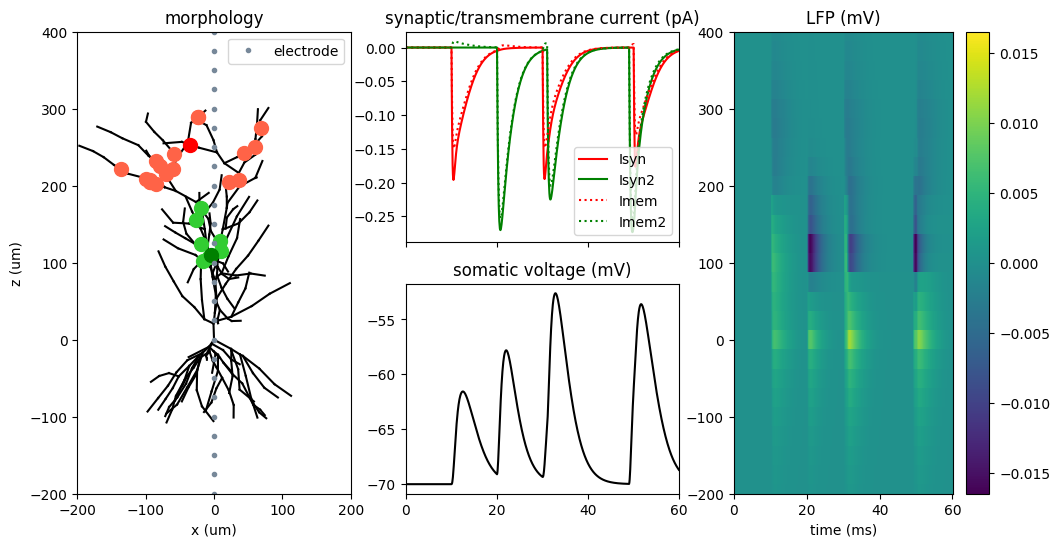

In [59]:
fig = plt.figure(figsize=(12, 6))
gs = GridSpec(2, 3)

ax0 = fig.add_subplot(gs[:, 0])
ax0.plot(cell.x.T, cell.z.T, 'k')
for synapse in synapses[1:-1]:
  ax0.plot(synapse.x, synapse.z,
          color='tomato', marker='o', markersize=10)
ax0.plot(synapses[0].x, synapses[0].z,
        color='r', marker='o', markersize=10)

for synapse2 in synapses2[1:-1]:
  ax0.plot(synapse2.x, synapse2.z,
          color='limegreen', marker='o', markersize=10)
ax0.plot(synapses2[0].x, synapses2[0].z,
        color='g', marker='o', markersize=10)
ax0.plot(lsp.x, lsp.z, '.', color='lightslategrey',
        label='electrode')
ax0.axis([-200, 200, -200, 400])
ax0.legend()
ax0.set_xlabel('x (um)')
ax0.set_ylabel('z (um)')
ax0.set_title('morphology')

ax1 = fig.add_subplot(gs[0, 1])
ax1.plot(cell.tvec, synapses[0].i, color='r',label='Isyn')
ax1.plot(cell.tvec, synapses2[0].i, color='g',label='Isyn2')
ax1.plot(cell.tvec, cell.imem[sec_n[0]],':', color='r',label='Imem')
ax1.plot(cell.tvec, cell.imem[sec_n2[0]],':', color='g',label='Imem2')
ax1.set_title('synaptic/transmembrane current (pA)')
plt.setp(ax1.get_xticklabels(), visible=False)
ax1.legend()

ax2 = fig.add_subplot(gs[1, 1], sharex=ax1)
ax2.plot(cell.tvec, cell.somav, 'k')
ax2.set_title('somatic voltage (mV)')

ax3 = fig.add_subplot(gs[:, 2], sharey=ax0, sharex=ax1)
im = ax3.pcolormesh(cell.tvec, lsp.z, lsp.data,
                 vmin=-abs(lsp.data).max(), vmax=abs(lsp.data).max(),
                 shading='auto')
plt.colorbar(im)
ax3.set_title('LFP (mV)')
ax3.set_xlabel('time (ms)')

#savefig('LFPy-example-two_inputs.pdf', dpi=300)

In [60]:
!pip install git+https://github.com/Neuroinflab/kCSD-python.git


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/Neuroinflab/kCSD-python.git to /tmp/pip-req-build-gud1ckd0
  Running command git clone --filter=blob:none --quiet https://github.com/Neuroinflab/kCSD-python.git /tmp/pip-req-build-gud1ckd0
  Resolved https://github.com/Neuroinflab/kCSD-python.git to commit de7fd0c4a99b69935a0c06aef1be7f68426e7d69
  Preparing metadata (setup.py) ... done


In [61]:
from kcsd import KCSD1D

def do_kcsd(ele_pos, pots):
    h = 50.  # distance between the electrode plane and the midslice
    sigma = 1.0 # S/m
    ele_pos = ele_pos.reshape((len(ele_pos), 1))
    pots = pots.reshape((len(ele_pos), -1)) # first time point
    k = KCSD1D(ele_pos, pots, h=h, sigma=sigma,
               xmin=ele_pos.min(), xmax=ele_pos.max(),
               n_src_init=100, src_type='gauss', R_init=10.)
    return k


k = do_kcsd(lsp.z, lsp.data)
est_csd = k.values('CSD')

Text(0.5, 0, 'time (ms)')

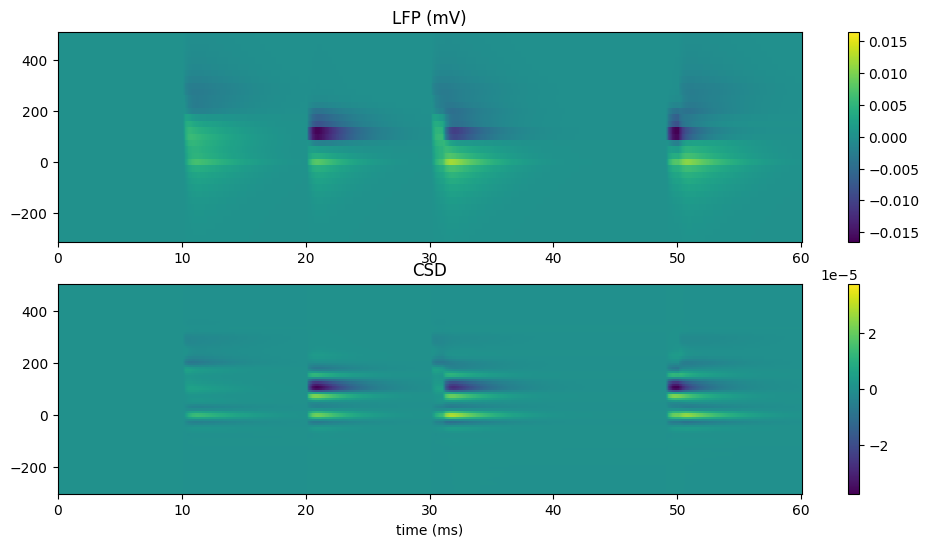

In [64]:
fig_csd = plt.figure(figsize=(12, 6))
gs = GridSpec(2, 1)

ax0 = fig_csd.add_subplot(gs[0,:])
im = ax0.pcolormesh(cell.tvec, lsp.z, lsp.data,
                 vmin=-abs(lsp.data).max(), vmax=abs(lsp.data).max(),
                 shading='auto')
plt.colorbar(im)
ax0.set_title('LFP (mV)')
# ax0.set_xlabel('time (ms)')

ax1 = fig_csd.add_subplot(gs[1,:], sharex=ax0)
im_csd = ax1.pcolormesh(cell.tvec, k.estm_x, est_csd,
                 vmin=-abs(est_csd).max(), vmax=abs(est_csd).max(),
                 shading='auto')
plt.colorbar(im_csd)
ax1.set_title('CSD')
ax1.set_xlabel('time (ms)')

In [ ]:
k.cross_validate(Rs=np.linspace(5, 40, 15))
est_csd = k.values('CSD')

No lambda given, using defaults
Cross validating R (all lambda) : 5.0


In [ ]:
fig_csdopt = plt.figure(figsize=(12, 6))
gs = GridSpec(2, 1)

ax0 = fig_csdopt.add_subplot(gs[0,:])
im = ax0.pcolormesh(cell.tvec, lsp.z, lsp.data,
                 vmin=-abs(lsp.data).max(), vmax=abs(lsp.data).max(),
                 shading='auto')
plt.colorbar(im)
ax0.set_title('LFP (mV)')

ax1 = fig_csdopt.add_subplot(gs[1,:], sharex=ax0)
im_csd = ax1.pcolormesh(cell.tvec, k.estm_x, est_csd,
                 vmin=-abs(est_csd).max(), vmax=abs(est_csd).max(),
                 shading='auto')

plt.colorbar(im_csd)
ax1.set_title('CSD')
ax1.set_xlabel('time (ms)')